# Model verification - Sysbench

In [1]:
from helpers.load_data import (
    clean_column_names,
    get_data_with_cpu,
    get_experiments_paths,
    remove_setup_datapoints,
    trim_experiment,
)
from helpers.regression import (
    boxplot_two,
    boxplot_grid,
    draw_regression_graph,
    fit_regression,
)

from datetime import datetime
from matplotlib.dates import DateFormatter
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.api as sm


plt.style.use('seaborn')

experiments_path = '../../data/basic'

## Sysbench vs Sysbench

In [2]:
instances_n=12
experiment_name='sysbench_1_sysbench_11'
workload_a = 'sysbench'
workload_b = 'sysbench'
perf_metric = 'app_latency'
path = get_experiments_paths(experiment_name, experiments_path)[0]
df = get_data_with_cpu(path, instances_n=instances_n, cpu_window=30)
df['time'] = pd.to_datetime(df['cbtool_time'], unit='s')

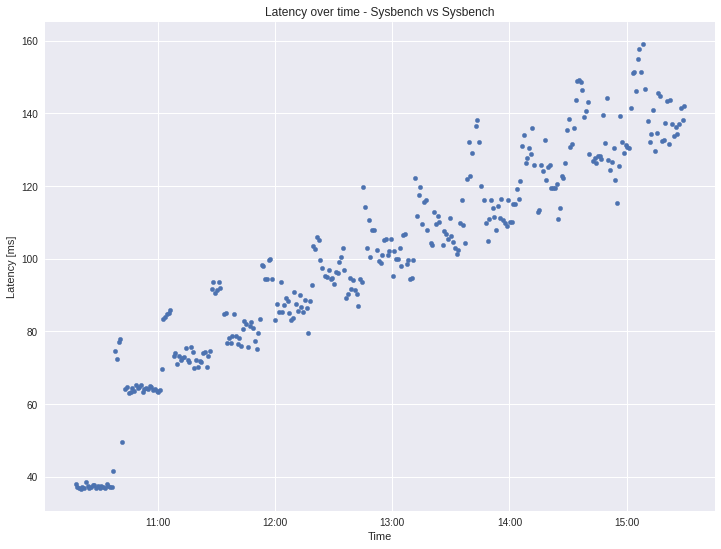

In [3]:
ax = df.plot.scatter(x='time', y=perf_metric, figsize=(12, 9))
ax.xaxis.set_major_formatter(DateFormatter('%H:%M'))
ax.set_title('Latency over time - Sysbench vs Sysbench')
ax.set_ylabel('Latency [ms]')
ax.set_xlabel('Time')
plt.savefig(f'graphs/{experiment_name}_perf_time_scatter_before_cleaning.png', bbox_inches='tight')

In [4]:
df = remove_setup_datapoints(df, path)

<AxesSubplot:xlabel='time', ylabel='app_latency'>

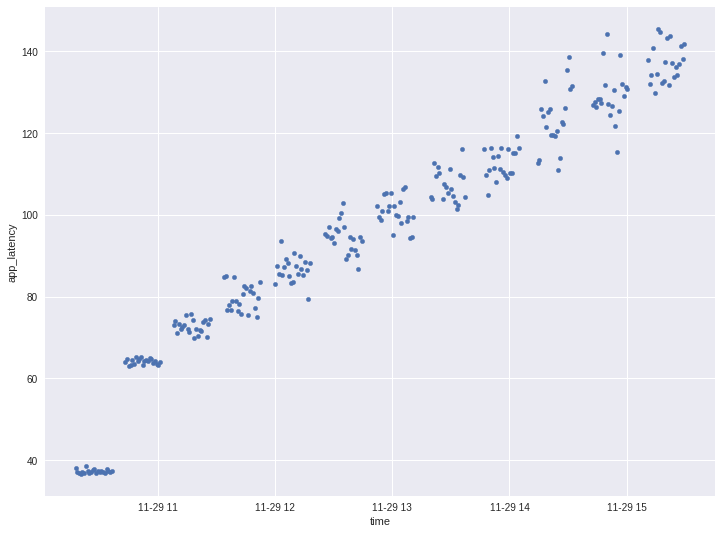

In [5]:
df.plot.scatter(x='time', y=perf_metric, figsize=(12, 9))
# plt.savefig(f'graphs/{experiment_name}_perf_time_scatter.png', bbox_inches='tight')

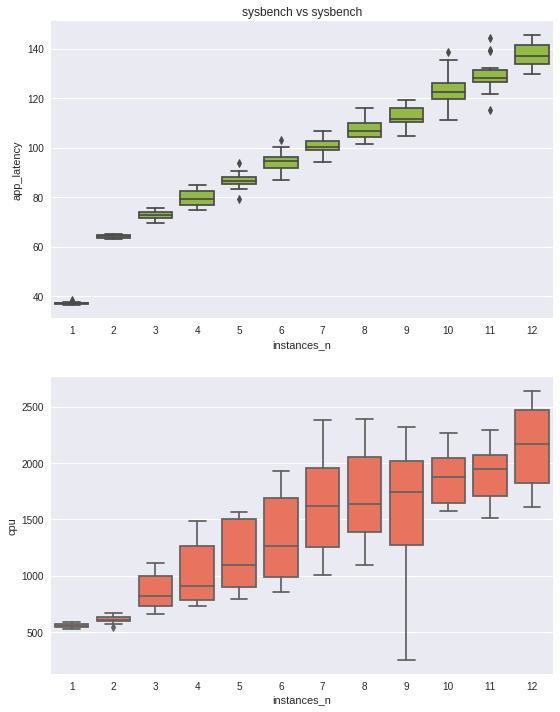

In [6]:
boxplot_two(perf_metric, 'cpu', df, (9,12), title=f'{workload_a} vs {workload_b}')
# plt.savefig(f'graphs/{experiment_name}_perf+cpu.png', bbox_inches='tight')

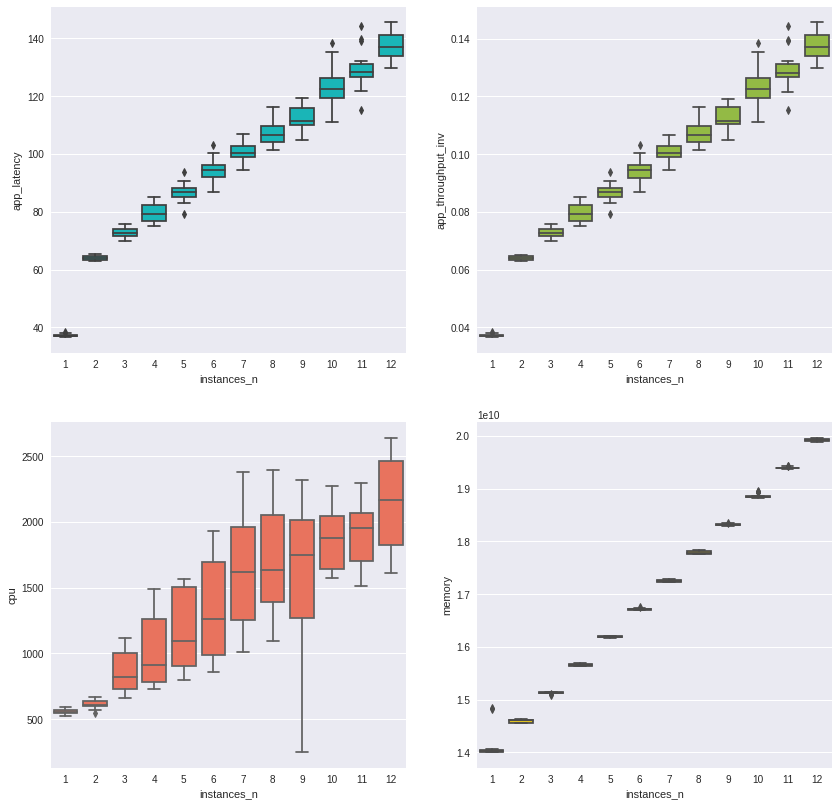

In [7]:
boxplot_grid(
    var_names=[['app_latency', 'app_throughput_inv'], ['cpu', 'memory']],
    figsize=[14, 14],
    dfs=[[df, df], [df, df]],
    titles=None,
    ylabels=None,
    suptitle=None
)

### Regression - whole experiment

In [8]:
results = fit_regression(data=df, formula=f'{perf_metric} ~ instances_n')
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            app_latency   R-squared:                       0.948
Model:                            OLS   Adj. R-squared:                  0.948
Method:                 Least Squares   F-statistic:                     4660.
Date:                Tue, 22 Jun 2021   Prob (F-statistic):          7.47e-166
Time:                        23:58:18   Log-Likelihood:                -843.61
No. Observations:                 257   AIC:                             1691.
Df Residuals:                     255   BIC:                             1698.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      43.6894      0.856     51.050      

In [9]:
# for table in results.summary().tables:
#     print(table.as_latex_tabular())

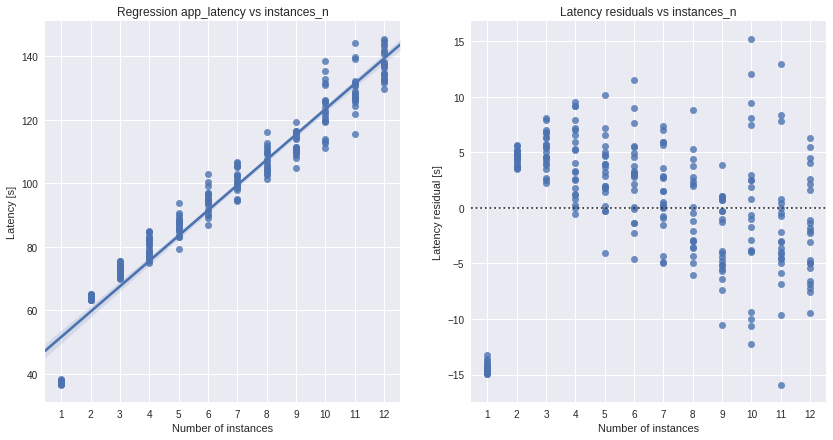

In [10]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))

sns.regplot(x='instances_n', y=perf_metric, data=df, ax=ax1, truncate=False)
ax1.set_title(f'Regression {perf_metric} vs instances_n')
ax1.set_ylabel(f'Latency [s]')
ax1.set_xlabel('Number of instances')
ax1.set_xticks(range(1,13))

sns.residplot(x='instances_n', y=perf_metric, data=df, ax=ax2)
ax2.set_title(f'Latency residuals vs instances_n')
ax2.set_ylabel(f'Latency residual [s]')
ax2.set_xlabel('Number of instances')
ax2.set_xticks(range(1,13))

pass
plt.savefig(f'graphs/{experiment_name}_instances_n_regplot_residplot.png', bbox_inches='tight')

#### Pvalues

In [11]:
results.pvalues

Intercept      6.998718e-136
instances_n    7.468663e-166
dtype: float64

In [12]:
print(f'Coefficient for instances_n: {results.params[1]:.6f}')

Coefficient for instances_n: 7.960935


#### Regression - CPU

In [13]:
results = fit_regression(data=df, formula=f'{perf_metric} ~ cpu')
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            app_latency   R-squared:                       0.681
Model:                            OLS   Adj. R-squared:                  0.679
Method:                 Least Squares   F-statistic:                     543.3
Date:                Tue, 22 Jun 2021   Prob (F-statistic):           3.88e-65
Time:                        23:58:19   Log-Likelihood:                -1077.2
No. Observations:                 257   AIC:                             2158.
Df Residuals:                     255   BIC:                             2165.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     41.1414      2.526     16.284      0.0

Text(0.5, 1.0, 'app_latency vs cpu')

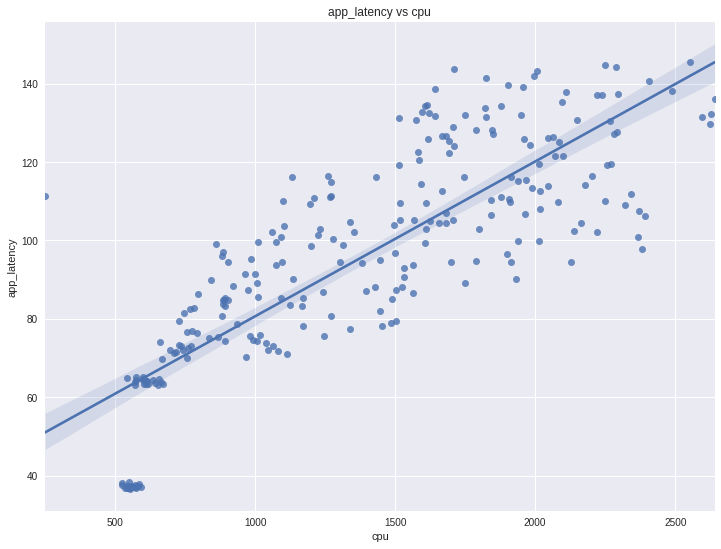

In [14]:
fig, ax = plt.subplots(figsize=(12, 9))
sns.regplot(x='cpu', y=perf_metric, data=df)
ax.set_title(f'{perf_metric} vs cpu')

Text(0, 0.5, 'Residual')

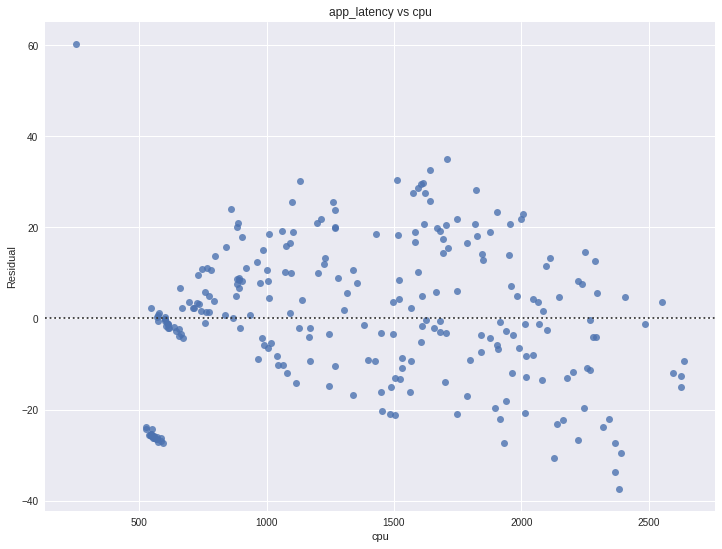

In [15]:
fig, ax = plt.subplots(figsize=(12, 9))
sns.residplot(x='cpu', y=perf_metric, data=df)
ax.set_title(f'{perf_metric} vs cpu')
ax.set_ylabel(f'Residual')

#### Regression - Memory

In [16]:
results = fit_regression(data=df, formula=f'{perf_metric} ~ memory')
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            app_latency   R-squared:                       0.945
Model:                            OLS   Adj. R-squared:                  0.945
Method:                 Least Squares   F-statistic:                     4363.
Date:                Tue, 22 Jun 2021   Prob (F-statistic):          2.10e-162
Time:                        23:58:19   Log-Likelihood:                -851.61
No. Observations:                 257   AIC:                             1707.
Df Residuals:                     255   BIC:                             1714.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -158.2350      3.859    -41.001      0.0

Text(0.5, 1.0, 'app_latency vs memory')

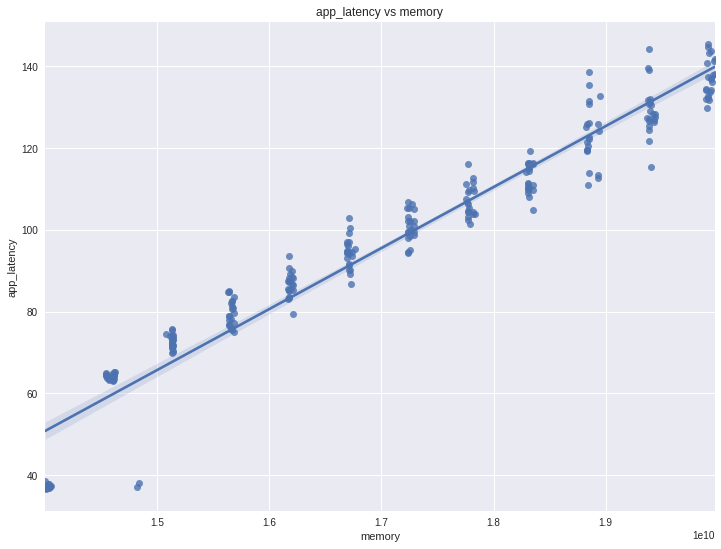

In [17]:
fig, ax = plt.subplots(figsize=(12, 9))
sns.regplot(x='memory', y=perf_metric, data=df)
ax.set_title(f'{perf_metric} vs memory')

Text(0, 0.5, 'Residual')

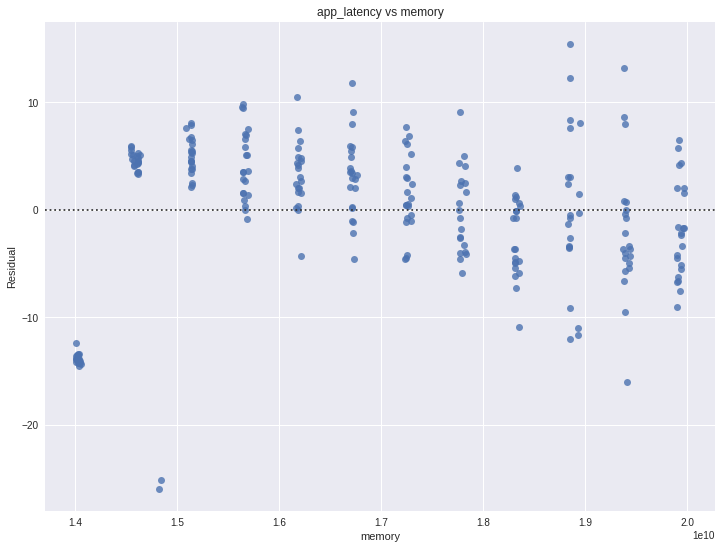

In [18]:
fig, ax = plt.subplots(figsize=(12, 9))
sns.residplot(x='memory', y=perf_metric, data=df)
ax.set_title(f'{perf_metric} vs memory')
ax.set_ylabel(f'Residual')

In [19]:
results = fit_regression(data=df, formula=f'{perf_metric} ~ instances_n + cpu')
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            app_latency   R-squared:                       0.948
Model:                            OLS   Adj. R-squared:                  0.948
Method:                 Least Squares   F-statistic:                     2323.
Date:                Tue, 22 Jun 2021   Prob (F-statistic):          5.87e-164
Time:                        23:58:20   Log-Likelihood:                -843.52
No. Observations:                 257   AIC:                             1693.
Df Residuals:                     254   BIC:                             1704.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      43.4584      1.022     42.529      

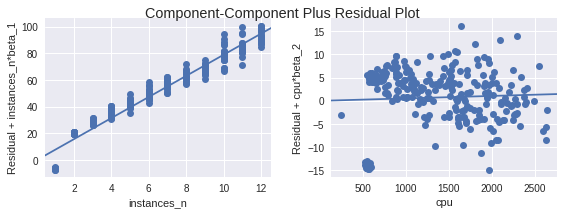

In [20]:
sm.graphics.plot_ccpr_grid(results)
fig.tight_layout(pad=1.0)

In [21]:
results = fit_regression(data=df, formula=f'{perf_metric} ~ instances_n + cpu + memory')
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            app_latency   R-squared:                       0.949
Model:                            OLS   Adj. R-squared:                  0.948
Method:                 Least Squares   F-statistic:                     1561.
Date:                Tue, 22 Jun 2021   Prob (F-statistic):          7.30e-163
Time:                        23:58:20   Log-Likelihood:                -842.02
No. Observations:                 257   AIC:                             1692.
Df Residuals:                     253   BIC:                             1706.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     173.7964     75.609      2.299      

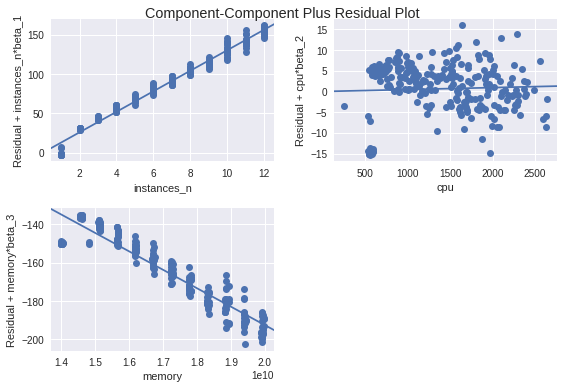

In [22]:
sm.graphics.plot_ccpr_grid(results)
fig.tight_layout(pad=1.0)

## Sysbench vs Redis YCSB

In [23]:
instances_n=12
experiment_name='sysbench_1_redis_ycsb_11'
workload_a = 'sysbench'
workload_b = 'redis_ycsb'
perf_metric = 'app_latency'
path = get_experiments_paths(experiment_name, experiments_path)[0]
df = get_data_with_cpu(path, instances_n=instances_n, cpu_window=30)
df['time'] = pd.to_datetime(df['cbtool_time'], unit='s')

<AxesSubplot:xlabel='time', ylabel='app_latency'>

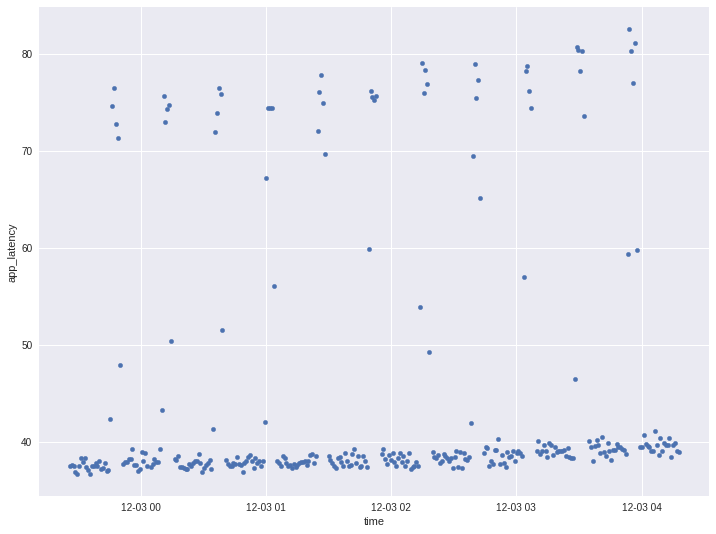

In [24]:
df.plot.scatter(x='time', y=perf_metric, figsize=(12, 9))
# plt.savefig(f'graphs/{experiment_name}_perf_time_scatter.png', bbox_inches='tight')

In [25]:
df = remove_setup_datapoints(df, path)

<AxesSubplot:xlabel='time', ylabel='app_latency'>

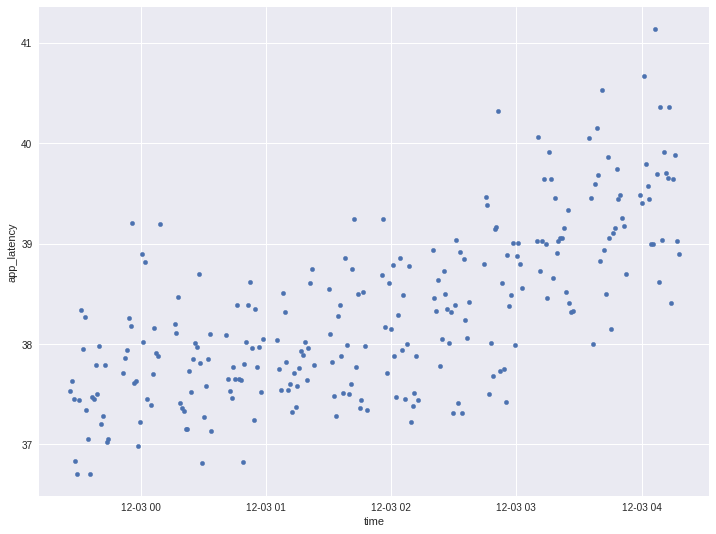

In [26]:
df.plot.scatter(x='time', y=perf_metric, figsize=(12, 9))
# plt.savefig(f'graphs/{experiment_name}_perf_time_scatter.png', bbox_inches='tight')

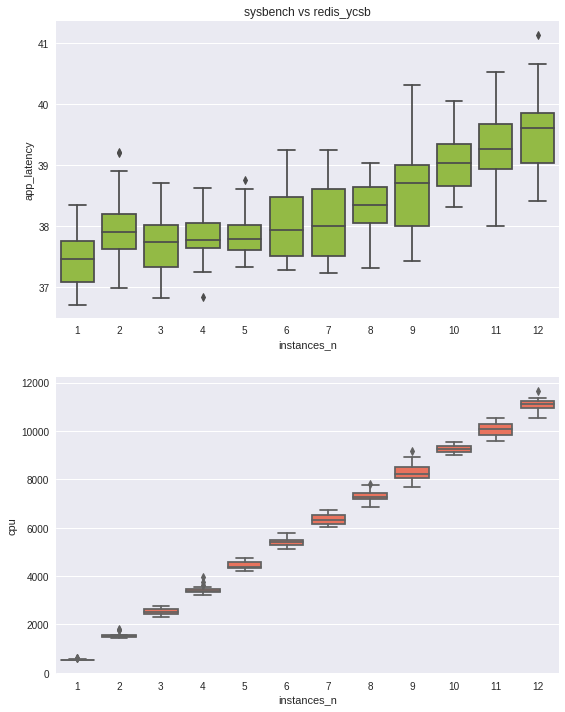

In [27]:
boxplot_two(perf_metric, 'cpu', df, (9,12), title=f'{workload_a} vs {workload_b}')
# plt.savefig(f'graphs/{experiment_name}_perf+cpu.png', bbox_inches='tight')

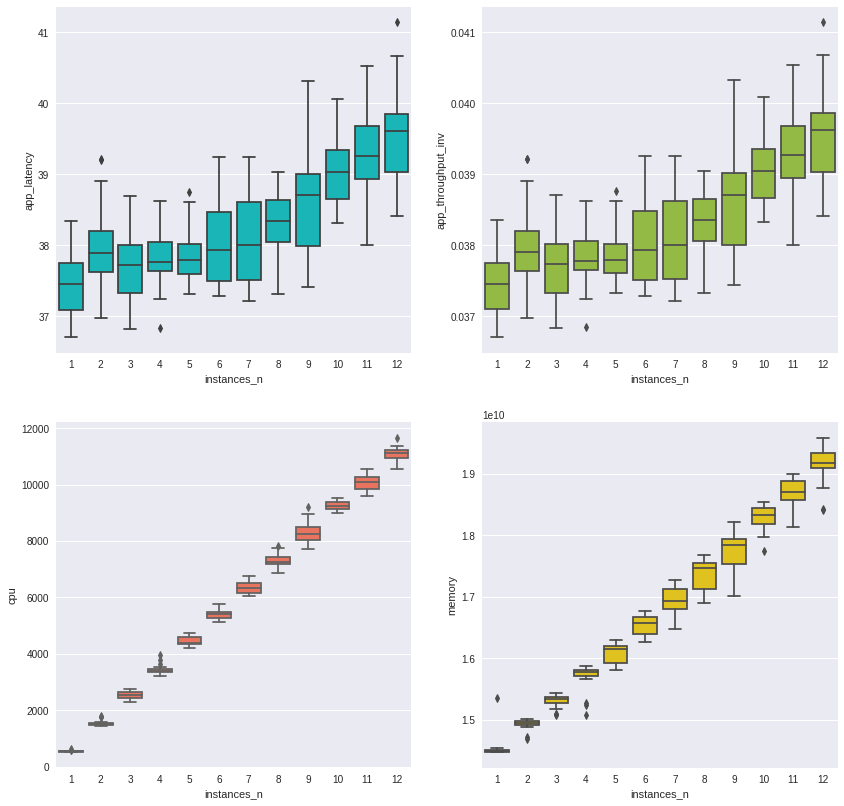

In [28]:
boxplot_grid(
    var_names=[['app_latency', 'app_throughput_inv'], ['cpu', 'memory']],
    figsize=[14, 14],
    dfs=[[df, df], [df, df]],
    titles=None,
    ylabels=None,
    suptitle=None
)

### Regression - whole experiment

In [29]:
results = fit_regression(data=df, formula=f'{perf_metric} ~ instances_n')
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            app_latency   R-squared:                       0.510
Model:                            OLS   Adj. R-squared:                  0.508
Method:                 Least Squares   F-statistic:                     263.1
Date:                Tue, 22 Jun 2021   Prob (F-statistic):           4.76e-41
Time:                        23:58:23   Log-Likelihood:                -227.40
No. Observations:                 255   AIC:                             458.8
Df Residuals:                     253   BIC:                             465.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      37.1763      0.079    469.096      

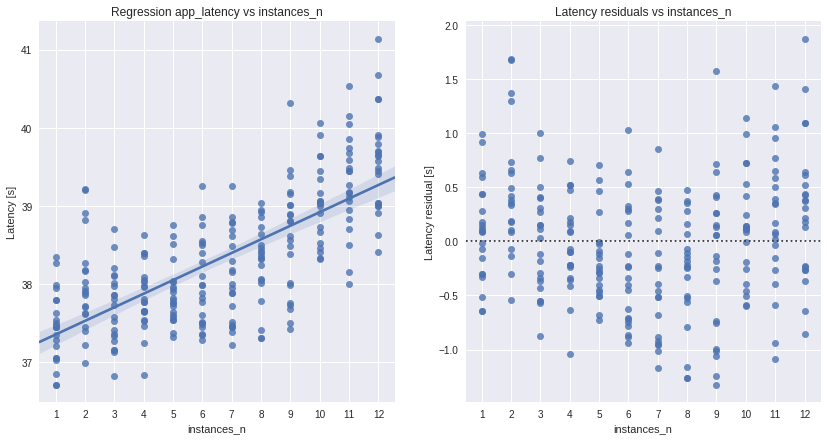

In [30]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))

sns.regplot(x='instances_n', y=perf_metric, data=df, ax=ax1, truncate=False)
ax1.set_title(f'Regression {perf_metric} vs instances_n')
ax1.set_ylabel(f'Latency [s]')
ax1.set_xticks(range(1,13))

sns.residplot(x='instances_n', y=perf_metric, data=df, ax=ax2)
ax2.set_title(f'Latency residuals vs instances_n')
ax2.set_ylabel(f'Latency residual [s]')
ax2.set_xticks(range(1,13))

pass
# plt.savefig(f'graphs/{experiment_name}_instances_n_regplot_residplot.png', bbox_inches='tight')

### Regression - trimmed

In [31]:
trim=9
df = trim_experiment(df, trim)

In [32]:
results = fit_regression(data=df, formula=f'{perf_metric} ~ instances_n')
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            app_latency   R-squared:                       0.211
Model:                            OLS   Adj. R-squared:                  0.206
Method:                 Least Squares   F-statistic:                     50.44
Date:                Tue, 22 Jun 2021   Prob (F-statistic):           2.42e-11
Time:                        23:58:24   Log-Likelihood:                -155.39
No. Observations:                 191   AIC:                             314.8
Df Residuals:                     189   BIC:                             321.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      37.4345      0.087    432.573      

In [33]:
# for table in results.summary().tables:
#     print(table.as_latex_tabular())

#### Pvalues

In [34]:
results.pvalues

Intercept      4.288507e-285
instances_n     2.423242e-11
dtype: float64

In [35]:
print(f'Coefficient for instances_n: {results.params[1]:.6f}')

Coefficient for instances_n: 0.108767


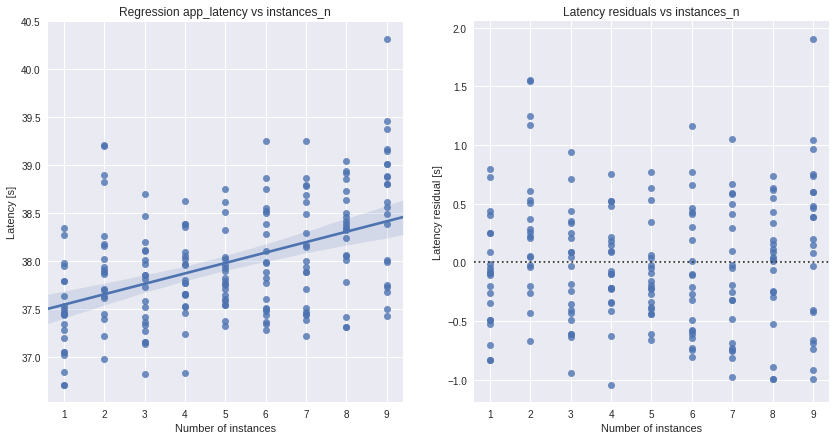

In [36]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))

sns.regplot(x='instances_n', y=perf_metric, data=df, ax=ax1, truncate=False)
ax1.set_title(f'Regression {perf_metric} vs instances_n')
ax1.set_ylabel(f'Latency [s]')
ax1.set_xlabel('Number of instances')
ax1.set_xticks(range(1,10))

sns.residplot(x='instances_n', y=perf_metric, data=df, ax=ax2)
ax2.set_title(f'Latency residuals vs instances_n')
ax2.set_ylabel(f'Latency residual [s]')
ax2.set_xlabel('Number of instances')
ax2.set_xticks(range(1,10))

pass
plt.savefig(f'graphs/{experiment_name}_instances_n_regplot_residplot.png', bbox_inches='tight')

#### Regression - CPU

In [37]:
results = fit_regression(data=df, formula=f'{perf_metric} ~ cpu')
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            app_latency   R-squared:                       0.213
Model:                            OLS   Adj. R-squared:                  0.208
Method:                 Least Squares   F-statistic:                     51.03
Date:                Tue, 22 Jun 2021   Prob (F-statistic):           1.91e-11
Time:                        23:58:25   Log-Likelihood:                -155.15
No. Observations:                 191   AIC:                             314.3
Df Residuals:                     189   BIC:                             320.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     37.4781      0.081    464.071      0.0

Text(0.5, 1.0, 'app_latency vs cpu')

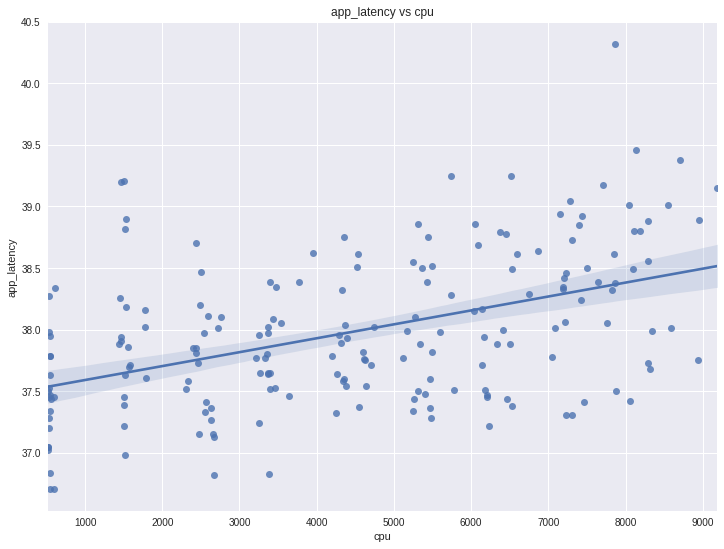

In [38]:
fig, ax = plt.subplots(figsize=(12, 9))
sns.regplot(x='cpu', y=perf_metric, data=df)
ax.set_title(f'{perf_metric} vs cpu')

Text(0, 0.5, 'Residual')

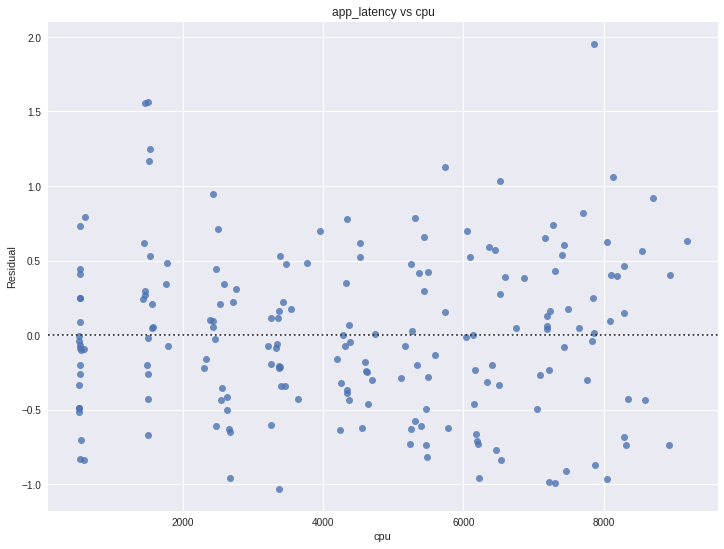

In [39]:
fig, ax = plt.subplots(figsize=(12, 9))
sns.residplot(x='cpu', y=perf_metric, data=df)
ax.set_title(f'{perf_metric} vs cpu')
ax.set_ylabel(f'Residual')

#### Regression - Memory

In [40]:
results = fit_regression(data=df, formula=f'{perf_metric} ~ memory')
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            app_latency   R-squared:                       0.191
Model:                            OLS   Adj. R-squared:                  0.186
Method:                 Least Squares   F-statistic:                     44.55
Date:                Tue, 22 Jun 2021   Prob (F-statistic):           2.67e-10
Time:                        23:58:25   Log-Likelihood:                -157.77
No. Observations:                 191   AIC:                             319.5
Df Residuals:                     189   BIC:                             326.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     33.9071      0.612     55.441      0.0

Text(0.5, 1.0, 'app_latency vs memory')

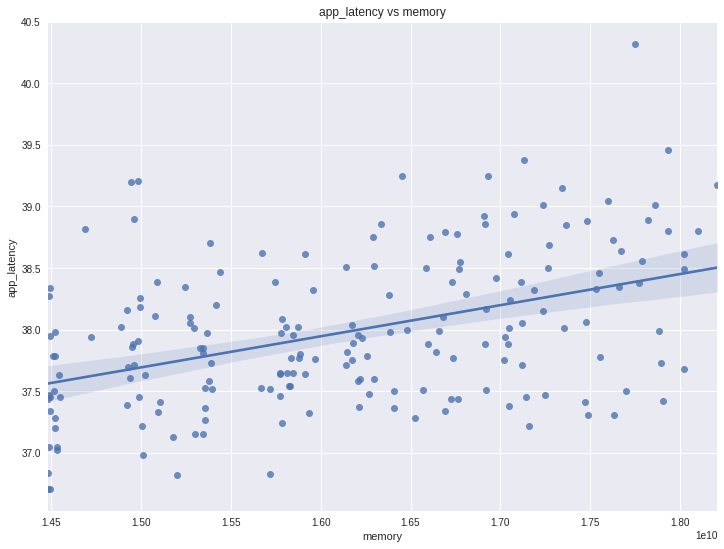

In [41]:
fig, ax = plt.subplots(figsize=(12, 9))
sns.regplot(x='memory', y=perf_metric, data=df)
ax.set_title(f'{perf_metric} vs memory')

Text(0, 0.5, 'Residual')

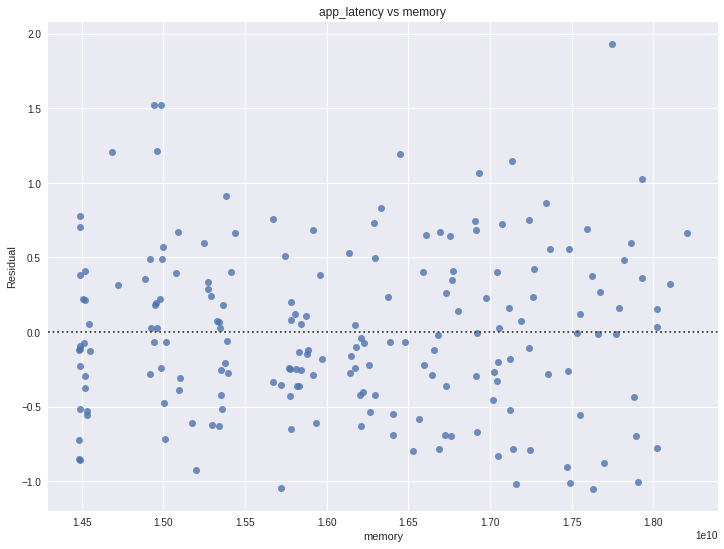

In [42]:
fig, ax = plt.subplots(figsize=(12, 9))
sns.residplot(x='memory', y=perf_metric, data=df)
ax.set_title(f'{perf_metric} vs memory')
ax.set_ylabel(f'Residual')

In [43]:
results = fit_regression(data=df, formula=f'{perf_metric} ~ instances_n + cpu')
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            app_latency   R-squared:                       0.213
Model:                            OLS   Adj. R-squared:                  0.204
Method:                 Least Squares   F-statistic:                     25.39
Date:                Tue, 22 Jun 2021   Prob (F-statistic):           1.74e-10
Time:                        23:58:26   Log-Likelihood:                -155.15
No. Observations:                 191   AIC:                             316.3
Df Residuals:                     188   BIC:                             326.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      37.4881      0.116    322.011      

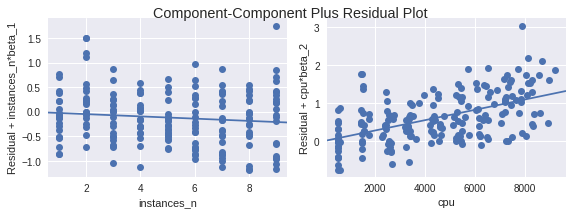

In [44]:
sm.graphics.plot_ccpr_grid(results)
fig.tight_layout(pad=1.0)

In [45]:
results = fit_regression(data=df, formula=f'{perf_metric} ~ instances_n + cpu + memory')
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            app_latency   R-squared:                       0.216
Model:                            OLS   Adj. R-squared:                  0.203
Method:                 Least Squares   F-statistic:                     17.16
Date:                Tue, 22 Jun 2021   Prob (F-statistic):           6.88e-10
Time:                        23:58:26   Log-Likelihood:                -154.75
No. Observations:                 191   AIC:                             317.5
Df Residuals:                     187   BIC:                             330.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      40.3059      3.197     12.606      

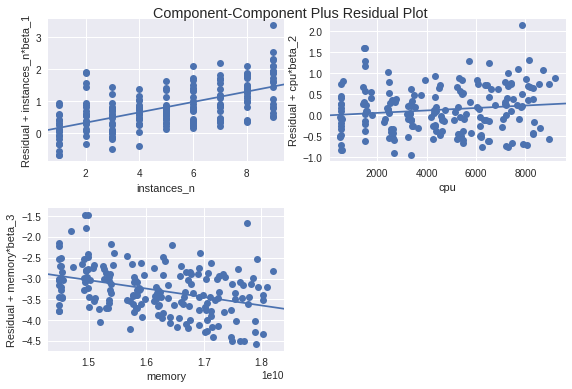

In [46]:
sm.graphics.plot_ccpr_grid(results)
fig.tight_layout(pad=1.0)

## Sysbench vs Linpack

In [47]:
instances_n=12
experiment_name='sysbench_1_linpack_11'
workload_a = 'sysbench'
workload_b = 'linpack'
perf_metric = 'app_latency'
path = get_experiments_paths(experiment_name, experiments_path)[0]
df = get_data_with_cpu(path, instances_n=instances_n, cpu_window=30)
df['time'] = pd.to_datetime(df['cbtool_time'], unit='s')

<AxesSubplot:xlabel='time', ylabel='app_latency'>

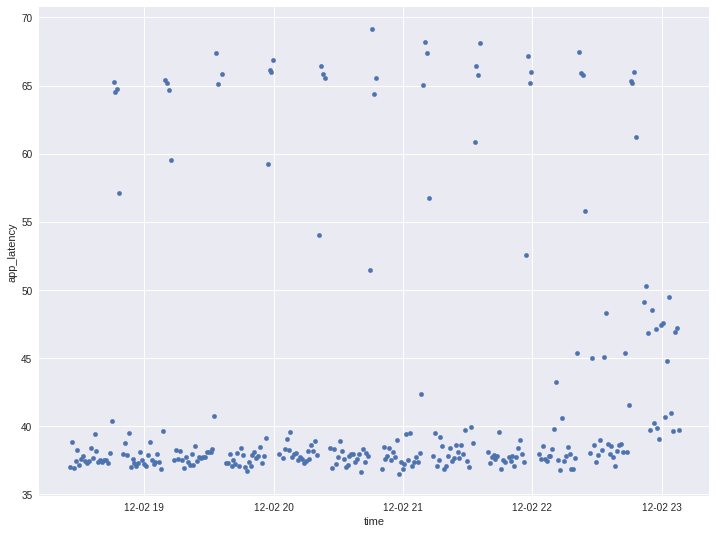

In [48]:
df.plot.scatter(x='time', y=perf_metric, figsize=(12, 9))
# plt.savefig(f'graphs/{experiment_name}_perf_time_scatter.png', bbox_inches='tight')

In [49]:
df = remove_setup_datapoints(df, path)

<AxesSubplot:xlabel='time', ylabel='app_latency'>

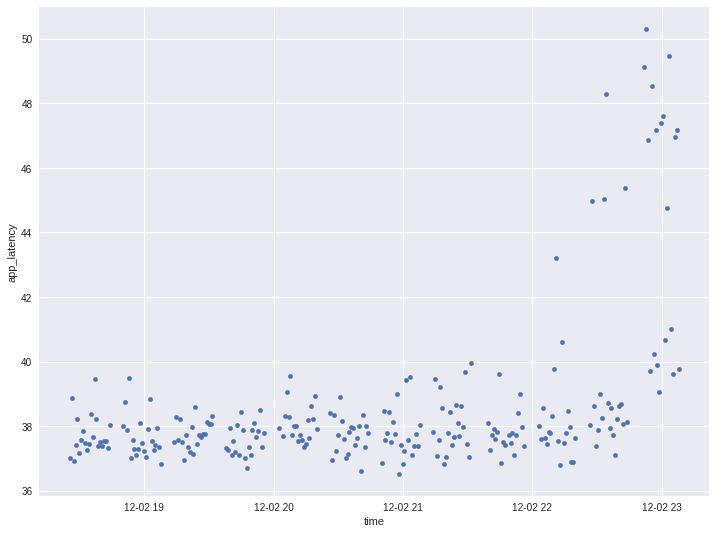

In [50]:
df.plot.scatter(x='time', y=perf_metric, figsize=(12, 9))
# plt.savefig(f'graphs/{experiment_name}_perf_time_scatter.png', bbox_inches='tight')

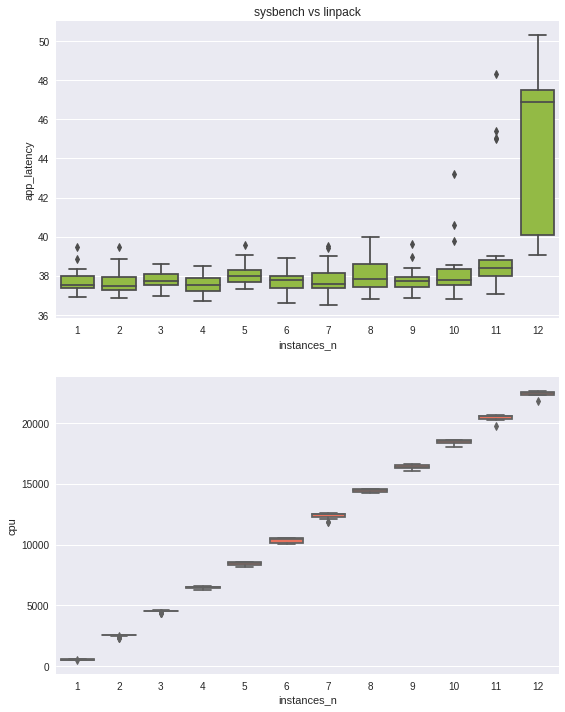

In [51]:
boxplot_two(perf_metric, 'cpu', df, (9,12), title=f'{workload_a} vs {workload_b}')
# plt.savefig(f'graphs/{experiment_name}_perf+cpu.png', bbox_inches='tight')

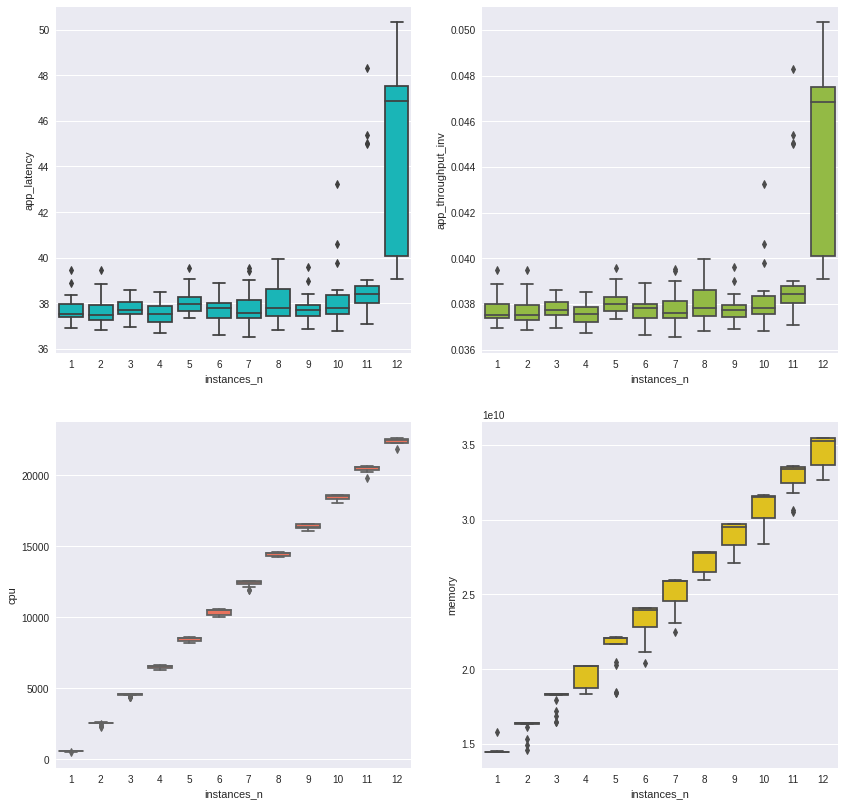

In [52]:
boxplot_grid(
    var_names=[['app_latency', 'app_throughput_inv'], ['cpu', 'memory']],
    figsize=[14, 14],
    dfs=[[df, df], [df, df]],
    titles=None,
    ylabels=None,
    suptitle=None
)

### Regression - whole experiment

In [53]:
results = fit_regression(data=df, formula=f'{perf_metric} ~ instances_n')
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            app_latency   R-squared:                       0.220
Model:                            OLS   Adj. R-squared:                  0.216
Method:                 Least Squares   F-statistic:                     68.66
Date:                Tue, 22 Jun 2021   Prob (F-statistic):           7.81e-15
Time:                        23:58:30   Log-Likelihood:                -535.58
No. Observations:                 246   AIC:                             1075.
Df Residuals:                     244   BIC:                             1082.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      36.4130      0.288    126.564      

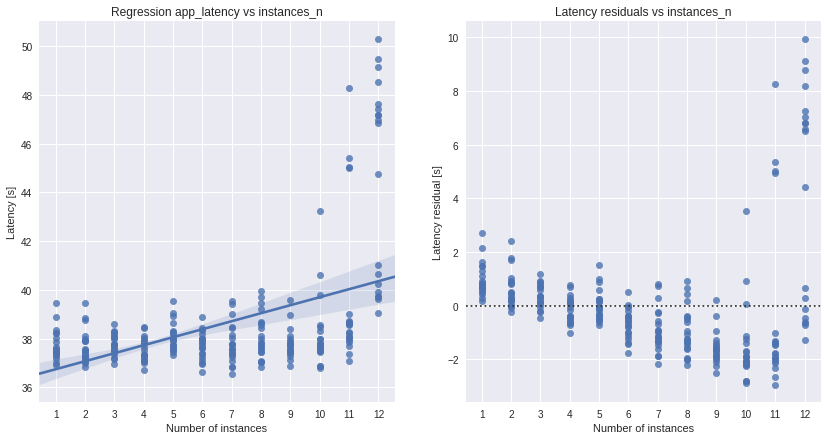

In [54]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))

sns.regplot(x='instances_n', y=perf_metric, data=df, ax=ax1, truncate=False)
ax1.set_title(f'Regression {perf_metric} vs instances_n')
ax1.set_ylabel(f'Latency [s]')
ax1.set_xlabel('Number of instances')
ax1.set_xticks(range(1,13))

sns.residplot(x='instances_n', y=perf_metric, data=df, ax=ax2)
ax2.set_title(f'Latency residuals vs instances_n')
ax2.set_ylabel(f'Latency residual [s]')
ax2.set_xlabel('Number of instances')
ax2.set_xticks(range(1,13))

pass
# plt.savefig(f'graphs/{experiment_name}_instances_n_regplot_residplot.png', bbox_inches='tight')

### Regression - trimmed

In [55]:
trim=5
df = trim_experiment(df, trim)

In [56]:
results = fit_regression(data=df, formula=f'{perf_metric} ~ instances_n')
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            app_latency   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     2.406
Date:                Tue, 22 Jun 2021   Prob (F-statistic):              0.124
Time:                        23:58:30   Log-Likelihood:                -89.660
No. Observations:                 105   AIC:                             183.3
Df Residuals:                     103   BIC:                             188.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      37.5788      0.130    289.051      

In [57]:
# for table in results.summary().tables:
#     print(table.as_latex_tabular())

#### Pvalues

In [58]:
results.pvalues

Intercept      1.116667e-151
instances_n     1.239620e-01
dtype: float64

In [59]:
print(f'Coefficient for instances_n: {results.params[1]:.6f}')

Coefficient for instances_n: 0.061440


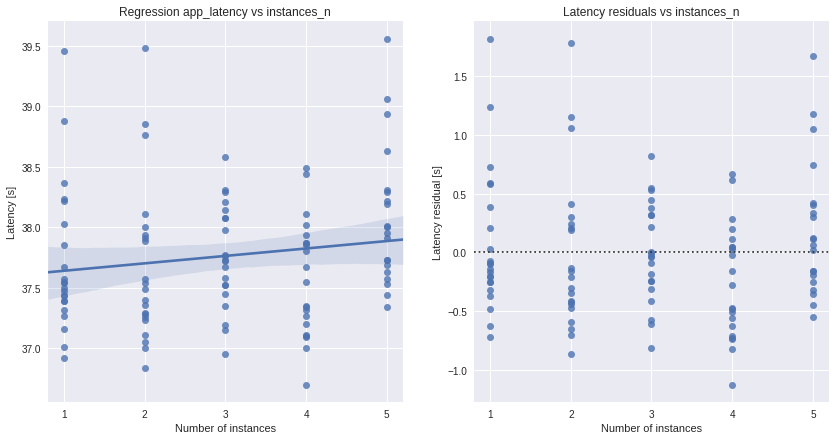

In [60]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))

sns.regplot(x='instances_n', y=perf_metric, data=df, ax=ax1, truncate=False)
ax1.set_title(f'Regression {perf_metric} vs instances_n')
ax1.set_ylabel(f'Latency [s]')
ax1.set_xlabel('Number of instances')
ax1.set_xticks(range(1,6))

sns.residplot(x='instances_n', y=perf_metric, data=df, ax=ax2)
ax2.set_title(f'Latency residuals vs instances_n')
ax2.set_ylabel(f'Latency residual [s]')
ax2.set_xlabel('Number of instances')
ax2.set_xticks(range(1,6))

pass
plt.savefig(f'graphs/{experiment_name}_instances_n_regplot_residplot.png', bbox_inches='tight')

#### Regression - CPU

In [61]:
results = fit_regression(data=df, formula=f'{perf_metric} ~ cpu')
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            app_latency   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     2.356
Date:                Tue, 22 Jun 2021   Prob (F-statistic):              0.128
Time:                        23:58:31   Log-Likelihood:                -89.684
No. Observations:                 105   AIC:                             183.4
Df Residuals:                     103   BIC:                             188.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     37.6246      0.105    358.599      0.0

Text(0.5, 1.0, 'app_latency vs cpu')

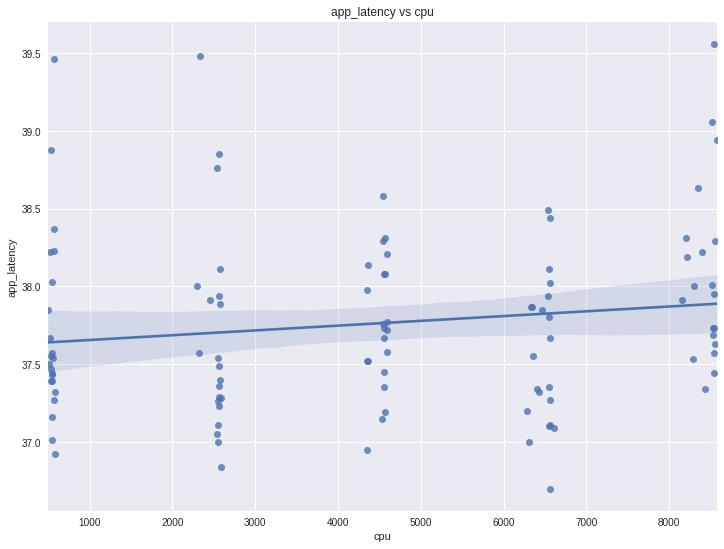

In [62]:
fig, ax = plt.subplots(figsize=(12, 9))
sns.regplot(x='cpu', y=perf_metric, data=df)
ax.set_title(f'{perf_metric} vs cpu')

Text(0, 0.5, 'Residual')

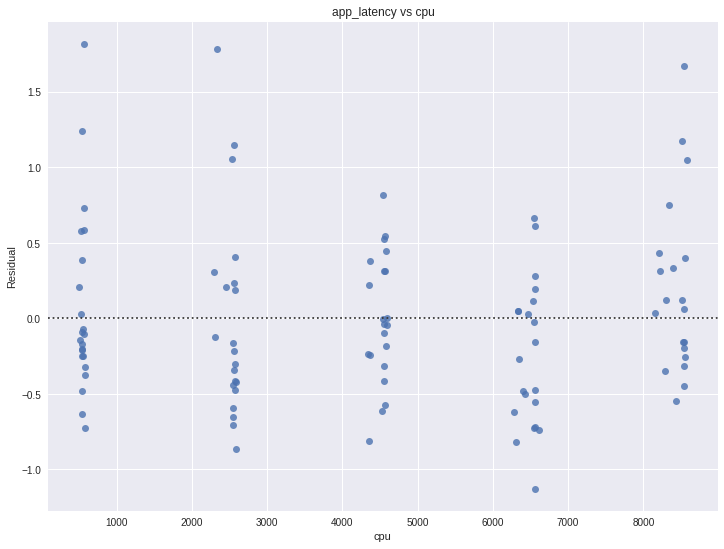

In [63]:
fig, ax = plt.subplots(figsize=(12, 9))
sns.residplot(x='cpu', y=perf_metric, data=df)
ax.set_title(f'{perf_metric} vs cpu')
ax.set_ylabel(f'Residual')

#### Regression - Memory

In [64]:
results = fit_regression(data=df, formula=f'{perf_metric} ~ memory')
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            app_latency   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     2.082
Date:                Tue, 22 Jun 2021   Prob (F-statistic):              0.152
Time:                        23:58:32   Log-Likelihood:                -89.821
No. Observations:                 105   AIC:                             183.6
Df Residuals:                     103   BIC:                             189.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     37.1938      0.397     93.713      0.0

Text(0.5, 1.0, 'app_latency vs memory')

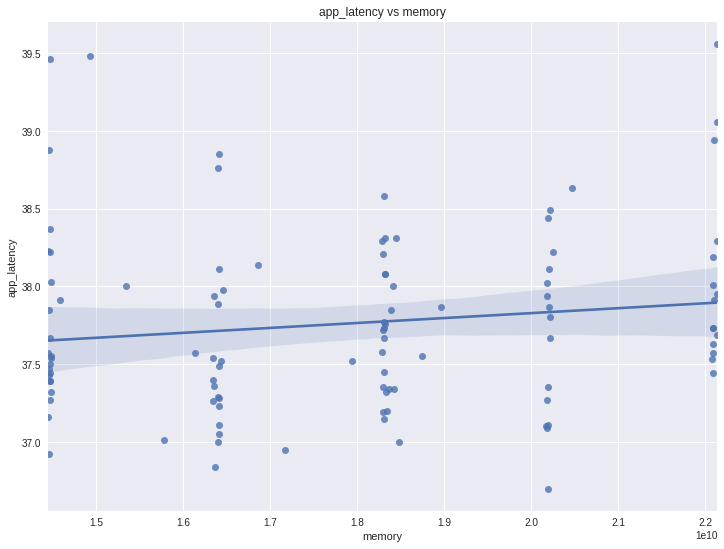

In [65]:
fig, ax = plt.subplots(figsize=(12, 9))
sns.regplot(x='memory', y=perf_metric, data=df)
ax.set_title(f'{perf_metric} vs memory')

Text(0, 0.5, 'Residual')

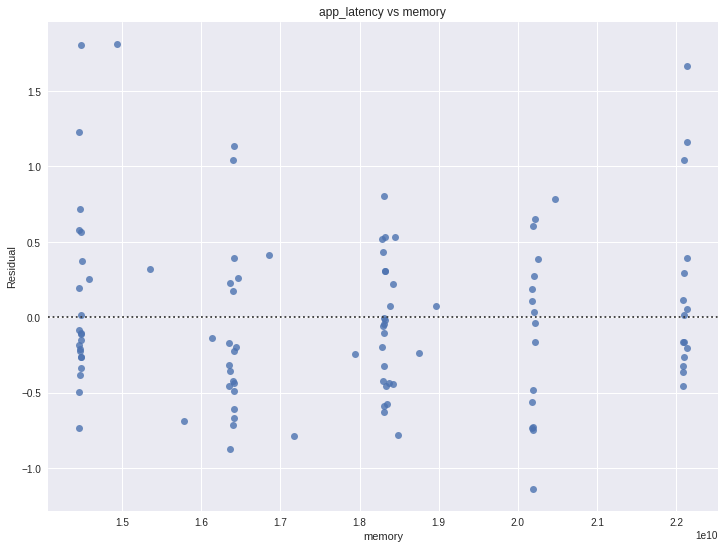

In [66]:
fig, ax = plt.subplots(figsize=(12, 9))
sns.residplot(x='memory', y=perf_metric, data=df)
ax.set_title(f'{perf_metric} vs memory')
ax.set_ylabel(f'Residual')

In [67]:
results = fit_regression(data=df, formula=f'{perf_metric} ~ instances_n + cpu')
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            app_latency   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     1.290
Date:                Tue, 22 Jun 2021   Prob (F-statistic):              0.280
Time:                        23:58:32   Log-Likelihood:                -89.561
No. Observations:                 105   AIC:                             185.1
Df Residuals:                     102   BIC:                             193.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      37.2061      0.859     43.295      

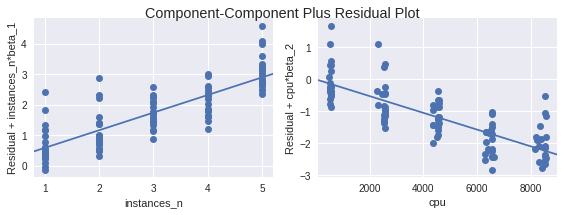

In [68]:
sm.graphics.plot_ccpr_grid(results)
fig.tight_layout(pad=1.0)

In [69]:
results = fit_regression(data=df, formula=f'{perf_metric} ~ instances_n + cpu + memory')
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            app_latency   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                    0.8668
Date:                Tue, 22 Jun 2021   Prob (F-statistic):              0.461
Time:                        23:58:33   Log-Likelihood:                -89.537
No. Observations:                 105   AIC:                             187.1
Df Residuals:                     101   BIC:                             197.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      36.8222      2.002     18.394      

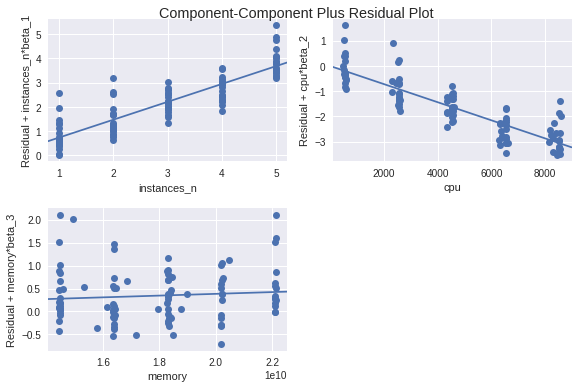

In [70]:
sm.graphics.plot_ccpr_grid(results)
fig.tight_layout(pad=1.0)

## Sysbench vs Hadoop

In [71]:
instances_n=8
experiment_name='sysbench_1_hadoop_pagerank_7'
workload_a = 'sysbench'
workload_b = 'hadoop'
perf_metric = 'app_latency'
path = get_experiments_paths(experiment_name, experiments_path)[1]
df = get_data_with_cpu(path, instances_n=instances_n, cpu_window=30)
df['time'] = pd.to_datetime(df['cbtool_time'], unit='s')

Text(0.5, 0, 'Time')

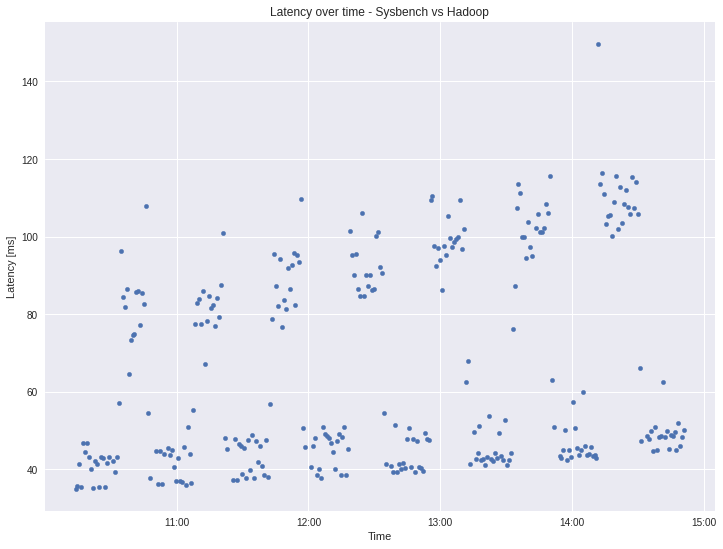

In [72]:
ax = df.plot.scatter(x='time', y=perf_metric, figsize=(12, 9))
ax.xaxis.set_major_formatter(DateFormatter('%H:%M'))
ax.set_title('Latency over time - Sysbench vs Hadoop')
ax.set_ylabel('Latency [ms]')
ax.set_xlabel('Time')
# plt.savefig(f'graphs/{experiment_name}_perf_time_scatter_before_cleaning.png', bbox_inches='tight')

In [73]:
df = remove_setup_datapoints(df, path, year=2021)

<AxesSubplot:xlabel='time', ylabel='app_latency'>

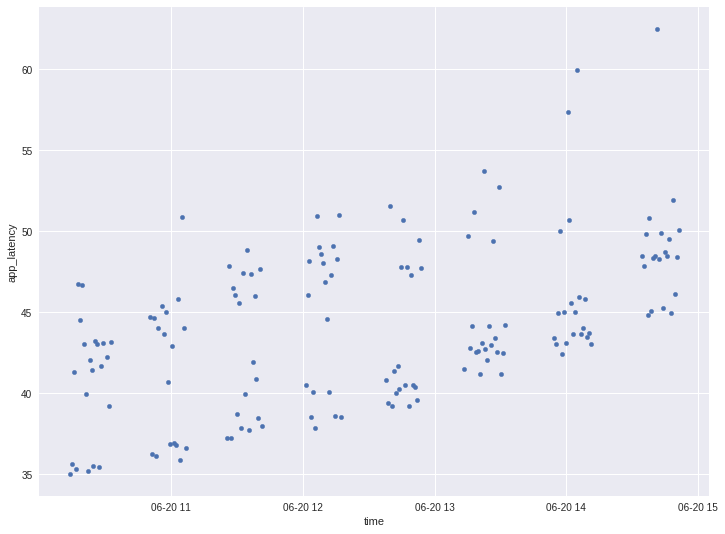

In [74]:
df.plot.scatter(x='time', y=perf_metric, figsize=(12, 9))
# plt.savefig(f'graphs/{experiment_name}_perf_time_scatter_after_cleaning.png', bbox_inches='tight')

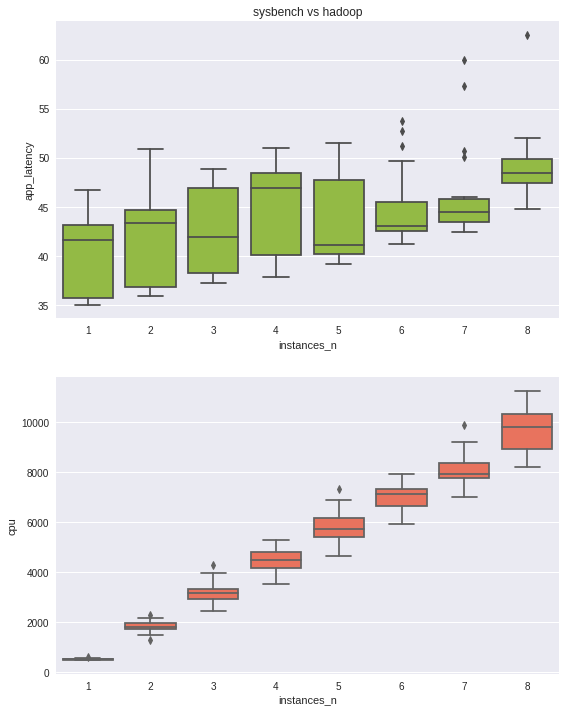

In [75]:
boxplot_two(perf_metric, 'cpu', df, (9,12), title=f'{workload_a} vs {workload_b}')
# plt.savefig(f'graphs/{experiment_name}_perf+cpu.png', bbox_inches='tight')

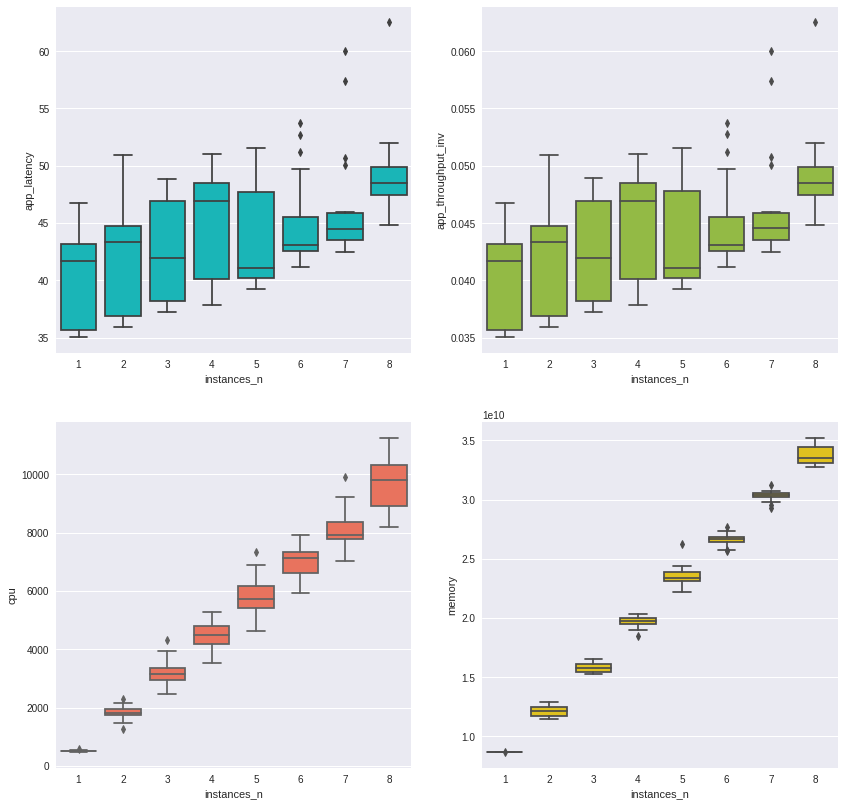

In [76]:
boxplot_grid(
    var_names=[['app_latency', 'app_throughput_inv'], ['cpu', 'memory']],
    figsize=[14, 14],
    dfs=[[df, df], [df, df]],
    titles=None,
    ylabels=None,
    suptitle=None
)

### Regression - whole experiment

In [77]:
results = fit_regression(data=df, formula=f'{perf_metric} ~ instances_n')
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            app_latency   R-squared:                       0.235
Model:                            OLS   Adj. R-squared:                  0.230
Method:                 Least Squares   F-statistic:                     47.73
Date:                Tue, 22 Jun 2021   Prob (F-statistic):           1.19e-10
Time:                        23:58:36   Log-Likelihood:                -450.99
No. Observations:                 157   AIC:                             906.0
Df Residuals:                     155   BIC:                             912.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      39.5125      0.756     52.287      

In [78]:
# h = df[['app_latency', 'cpu', 'memory', 'instances_n', 'app_completion_time']].head(5)
# t = df[['app_latency', 'cpu', 'memory', 'instances_n', 'app_completion_time']].tail(5)
# print(h.append(t).to_latex())

# for table in results.summary().tables:
#     print(table.as_latex_tabular())

Text(0.5, 1.0, 'app_latency vs instances_n')

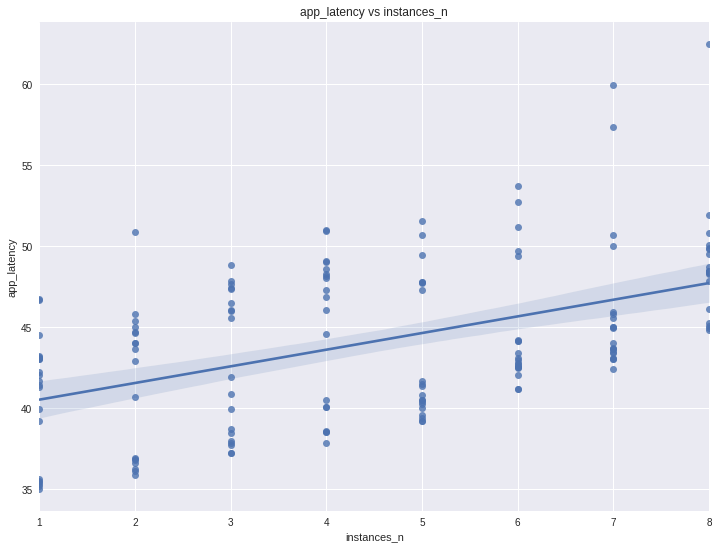

In [79]:
fig, ax = plt.subplots(figsize=(12, 9))
sns.regplot(x='instances_n', y=perf_metric, data=df)
ax.set_title(f'{perf_metric} vs instances_n')

Text(0, 0.5, 'Residual')

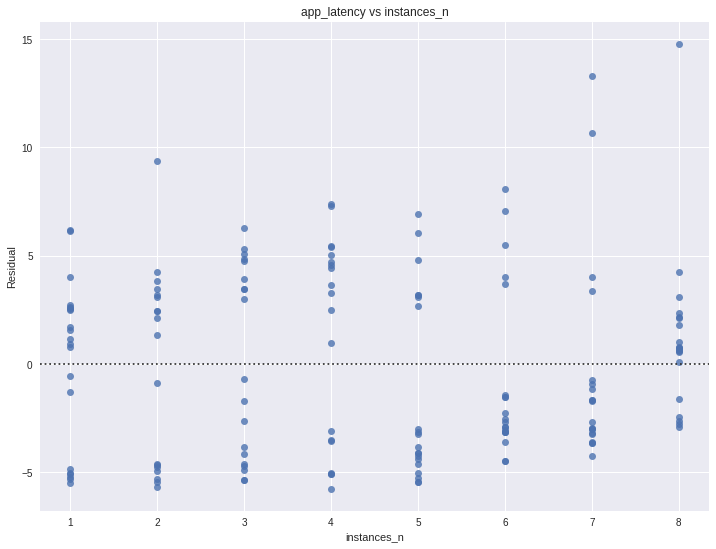

In [80]:
fig, ax = plt.subplots(figsize=(12, 9))
sns.residplot(x='instances_n', y=perf_metric, data=df)
ax.set_title(f'{perf_metric} vs instances_n')
ax.set_ylabel(f'Residual')

### Regression - trimmed

In [81]:
trim=6
df = trim_experiment(df, trim)
# df = df[df['app_latency'] < 60]

In [82]:
results = fit_regression(data=df, formula=f'{perf_metric} ~ instances_n')
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            app_latency   R-squared:                       0.102
Model:                            OLS   Adj. R-squared:                  0.095
Method:                 Least Squares   F-statistic:                     13.11
Date:                Tue, 22 Jun 2021   Prob (F-statistic):           0.000439
Time:                        23:58:36   Log-Likelihood:                -335.45
No. Observations:                 117   AIC:                             674.9
Df Residuals:                     115   BIC:                             680.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      40.0957      0.895     44.785      

#### Pvalues

In [83]:
results.pvalues

Intercept      1.257949e-74
instances_n    4.387742e-04
dtype: float64

In [84]:
print(f'Coefficient for instances_n: {results.params[1]:.6f}')

Coefficient for instances_n: 0.829142


Text(0.5, 1.0, 'app_latency vs instances_n')

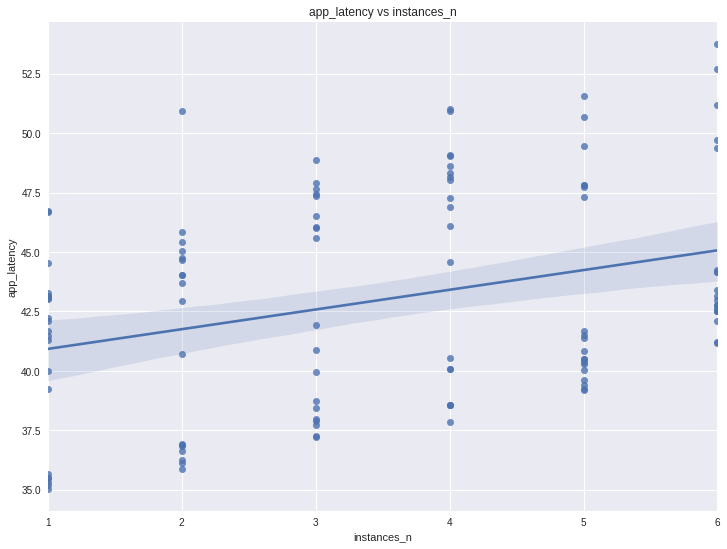

In [85]:
fig, ax = plt.subplots(figsize=(12, 9))
sns.regplot(x='instances_n', y=perf_metric, data=df)
ax.set_title(f'{perf_metric} vs instances_n')
# plt.savefig(f'graphs/{experiment_name}_instances_n_regression.png', bbox_inches='tight')

Text(0, 0.5, 'Residual')

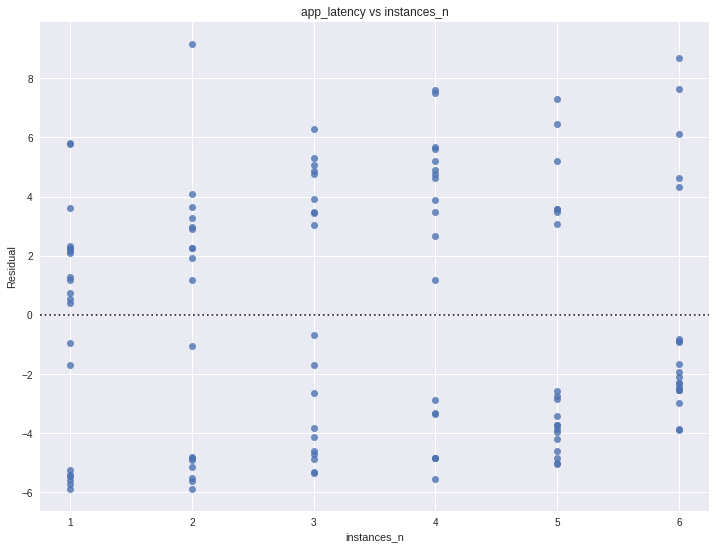

In [86]:
fig, ax = plt.subplots(figsize=(12, 9))
sns.residplot(x='instances_n', y=perf_metric, data=df)
ax.set_title(f'{perf_metric} vs instances_n')
ax.set_ylabel(f'Residual')
# plt.savefig(f'graphs/{experiment_name}_instances_n_residual.png', bbox_inches='tight')

#### Regression - CPU

In [87]:
results = fit_regression(data=df, formula=f'{perf_metric} ~ cpu')
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            app_latency   R-squared:                       0.095
Model:                            OLS   Adj. R-squared:                  0.087
Method:                 Least Squares   F-statistic:                     12.04
Date:                Tue, 22 Jun 2021   Prob (F-statistic):           0.000736
Time:                        23:58:37   Log-Likelihood:                -335.94
No. Observations:                 117   AIC:                             675.9
Df Residuals:                     115   BIC:                             681.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     40.7197      0.769     52.954      0.0

Text(0.5, 1.0, 'app_latency vs cpu')

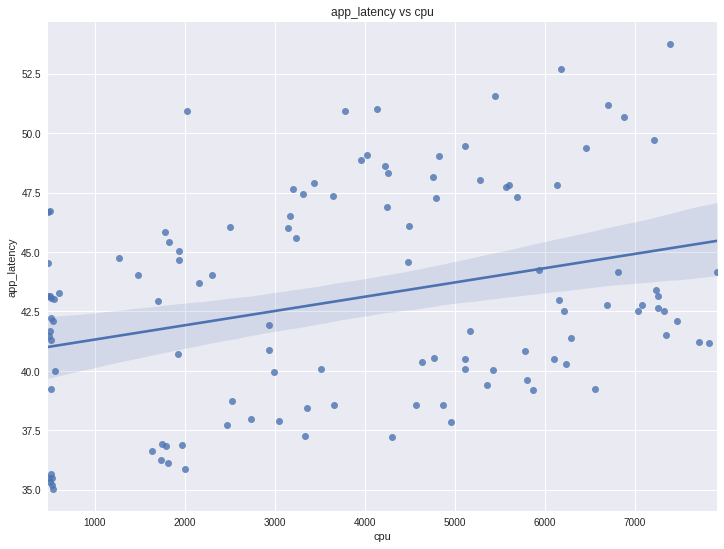

In [88]:
fig, ax = plt.subplots(figsize=(12, 9))
sns.regplot(x='cpu', y=perf_metric, data=df)
ax.set_title(f'{perf_metric} vs cpu')

Text(0, 0.5, 'Residual')

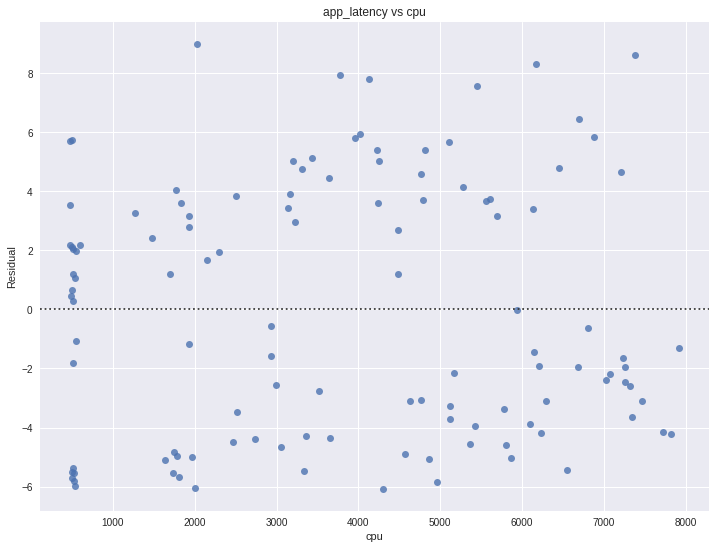

In [89]:
fig, ax = plt.subplots(figsize=(12, 9))
sns.residplot(x='cpu', y=perf_metric, data=df)
ax.set_title(f'{perf_metric} vs cpu')
ax.set_ylabel(f'Residual')

#### Regression - Memory

In [90]:
results = fit_regression(data=df, formula=f'{perf_metric} ~ memory')
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            app_latency   R-squared:                       0.105
Model:                            OLS   Adj. R-squared:                  0.097
Method:                 Least Squares   F-statistic:                     13.48
Date:                Tue, 22 Jun 2021   Prob (F-statistic):           0.000367
Time:                        23:58:38   Log-Likelihood:                -335.28
No. Observations:                 117   AIC:                             674.6
Df Residuals:                     115   BIC:                             680.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     38.9301      1.177     33.062      0.0

Text(0.5, 1.0, 'app_latency vs memory')

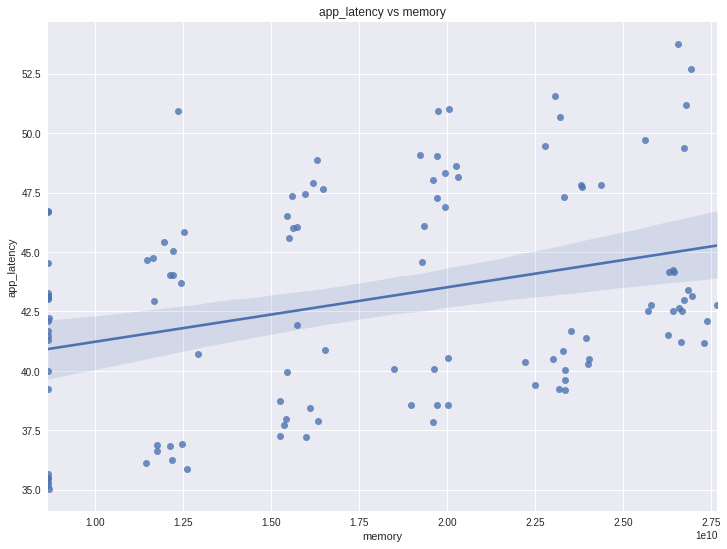

In [91]:
fig, ax = plt.subplots(figsize=(12, 9))
sns.regplot(x='memory', y=perf_metric, data=df)
ax.set_title(f'{perf_metric} vs memory')

Text(0, 0.5, 'Residual')

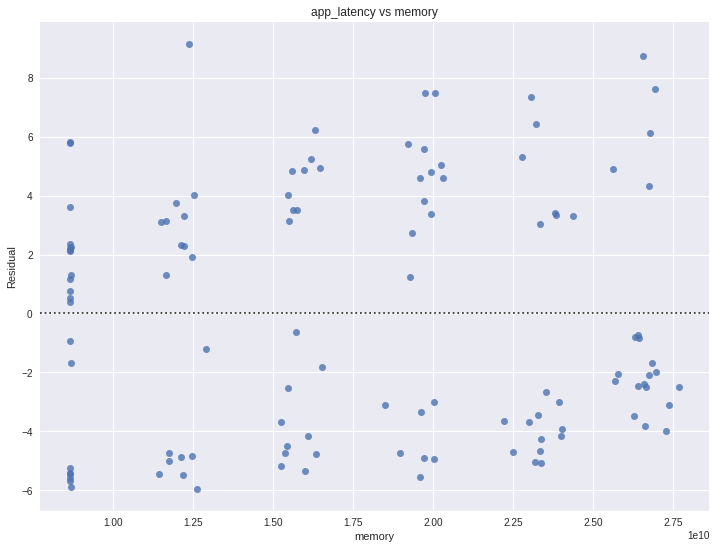

In [92]:
fig, ax = plt.subplots(figsize=(12, 9))
sns.residplot(x='memory', y=perf_metric, data=df)
ax.set_title(f'{perf_metric} vs memory')
ax.set_ylabel(f'Residual')

In [93]:
results = fit_regression(data=df, formula=f'{perf_metric} ~ instances_n + cpu')
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            app_latency   R-squared:                       0.103
Model:                            OLS   Adj. R-squared:                  0.087
Method:                 Least Squares   F-statistic:                     6.559
Date:                Tue, 22 Jun 2021   Prob (F-statistic):            0.00201
Time:                        23:58:38   Log-Likelihood:                -335.39
No. Observations:                 117   AIC:                             676.8
Df Residuals:                     114   BIC:                             685.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      39.8708      1.123     35.497      

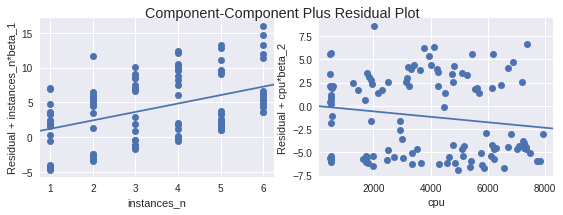

In [94]:
sm.graphics.plot_ccpr_grid(results)
fig.tight_layout(pad=1.0)

In [95]:
results = fit_regression(data=df, formula=f'{perf_metric} ~ instances_n + cpu + memory')
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            app_latency   R-squared:                       0.110
Model:                            OLS   Adj. R-squared:                  0.086
Method:                 Least Squares   F-statistic:                     4.643
Date:                Tue, 22 Jun 2021   Prob (F-statistic):            0.00424
Time:                        23:58:39   Log-Likelihood:                -334.97
No. Observations:                 117   AIC:                             677.9
Df Residuals:                     113   BIC:                             689.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      35.8499      4.553      7.873      

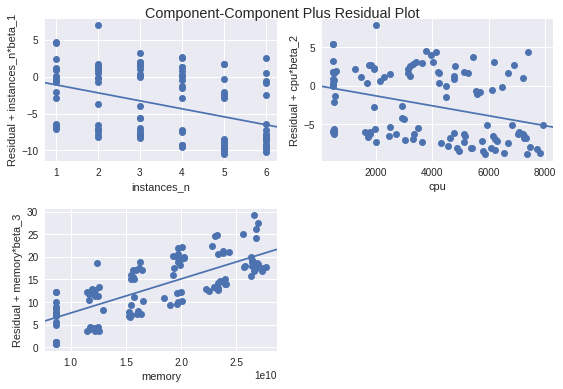

In [96]:
sm.graphics.plot_ccpr_grid(results)
fig.tight_layout(pad=1.0)